# import 

In [82]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)
    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

In [13]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.json
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv


In [92]:
filename = 'tweets/freeyouth_tweet.json'
filename = 'tweets/badstudent_tweet.json'
num = 20

# frequent hashtag & cooccurent words

In [93]:
df = pd.read_json(filename, lines=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date <= '2020-12-31')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))

##### hashtags #####
hashtag_counter = Counter()
for lst in df.hashtags:
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in df.iterrows():
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

|hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|นักเรียนเลว|324|นักเรียน(679) เลว(365) โรงเรียน(280) ครู(136) กระทรวง(63) ม็อบ(53) ทรงผม(50) หนู(47) กระทรวงศึกษาธิการ(43) ผม(42)|[2020-05-29 14:42:50](https://twitter.com/BadStudent_/status/1266273781590319105)<br>[@badstudent_](https://twitter.com/badstudent_)<br><br>ว่าด้วยงานศิลปหัตกรรม  16 พ.ค. (ไม่จัด) ประกาศในที่ประชุมยกเลิกการจัดกิจกรรมงานแข่งขันทั้งหมด  25 พ.ค. (จัด) สพฐ.ประชุมวางแผนจะจัดงานศิปหัตถรรม  28 พ.ค. (ไม่จัด) ศธ.ประกาศเลื่อนจัดงานศิลปหัตถรรม ——— #นักเรียนเลว|[2020-07-03 11:43:31](https://twitter.com/BadStudent_/status/1278912230843510784)<br>[@badstudent_](https://twitter.com/badstudent_)<br>62952 retweets<br><br>Breaking : ด่วนที่สุด!!! ปลัดศธ.ยืนยันแล้ว ทุกโรงเรียนต้องออกกฎทรงผมใหม่ตามระเบียบกระทรวงฯ ปี 63 ห้ามใช้กฎเดิม ย้ำ ห้ามใช้กฎเดิม!! โดยกระทรวงฯ จะส่งหนังสือถึงทุกโรงเรียนเพื่อยืนยันให้ปฏิบัติตามนี้อีกครั้ง —— #นักเรียนเลว #เลิกบังคับหรือจับตัด  https://t.co/2uyN3ywrK2|
|1ธันวาบอกลาเครื่องแบบ

In [51]:
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
31,1344688043140251650,1344688043140251648,2020-12-31 23:53:07+07:00,2020-12-31,23:53:07,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[แข็งแกร่ง, ห้าง, นายทุน, ริมแม่น้ำ, เจ้าพระยา..."
32,1344669316864761862,1344669316864761856,2020-12-31 22:38:42+07:00,2020-12-31,22:38:42,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[การเคลื่อนไหว, เยาวชน, ปลดแอก, ปี]"
33,1343878546947760128,1343878546947760128,2020-12-29 18:16:28+07:00,2020-12-29,18:16:28,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[ชม., เตรียม, สังคมนิยม, ปรสิต, สังคม, ดู, รัฐ..."
34,1343448307255758848,1343447873837535232,2020-12-28 13:46:51+07:00,2020-12-28,13:46:51,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[พระ, อัจฉริยภาพ, โอนย้าย, ทรัพย์สิน, ส่วนรวม,..."
35,1343448258019000320,1343447873837535232,2020-12-28 13:46:39+07:00,2020-12-28,13:46:39,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[ทุนนิยม, ร่ำรวย, ล้นฟ้า, อยู่แล้ว, งบประมาณ, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1231935067838009344,1231875127647752192,2020-02-24 20:33:03+07:00,2020-02-24,20:33:03,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[ตอนนี้, นิรนาม, ประกันตัว, วงเงิน, บาท, ขอบคุ..."
1596,1231875127647752194,1231875127647752192,2020-02-24 16:34:52+07:00,2020-02-24,16:34:52,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[นิรนาม, ปลดปล่อย, เพื่อน, เยาวชน, นิรนาม, เยา..."
1597,1231534209593774080,1231534209593774080,2020-02-23 18:00:11+07:00,2020-02-23,18:00:11,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,[],,,,,"[เวลา, นาฬิกา, ประเทศ, อภิปราย, ไว้วางใจ, สภา,..."
1598,1230880786619850752,1230880676905287680,2020-02-21 22:43:42+07:00,2020-02-21,22:43:42,700,1214182673641422848,freeyouthth,FreeYOUTH,,...,,,,,"[{'screen_name': 'fordtattepRuang', 'name': 'F...",,,,,[ใจ]


In [19]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']

df.to_csv(filename.replace('.json','_raw.csv'), index=False)
df[column].to_csv(filename.replace('.json','.csv'), index=False)

# hashtag timeseries

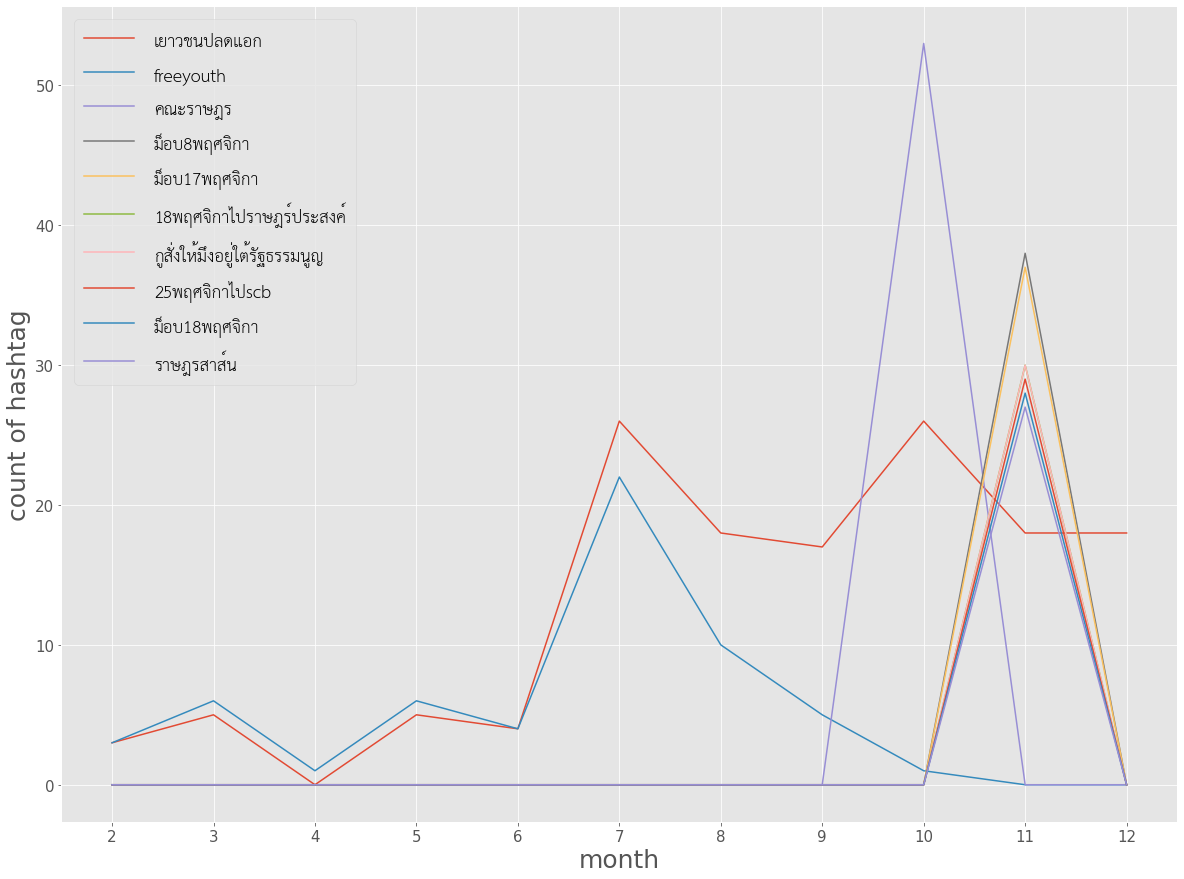

In [53]:
### plot time series ###

start_m = 2
xs = list(range(start_m, 13))

fig = plt.figure(figsize=(20,15))

for tag, count in hashtag_counter.most_common(10):
    counts = []  
    for m in range(start_m, 13):
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(xs, counts, label=tag)

plt.xticks(xs, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of hashtag', size=25)
plt.show()

# LDA

In [94]:
%%time

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 985/985 [00:00<00:00, 30073.37it/s]


CPU times: user 13.2 s, sys: 105 ms, total: 13.3 s
Wall time: 13.5 s


In [95]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|เรียน|0.018|นักเรียน|0.076|นักเรียน|0.056|คน|0.016|นักเรียน|0.055|
|2|โรงเรียน|0.015|โรงเรียน|0.040|เลว|0.024|ม.|0.010|โรงเรียน|0.033|
|3|เด็ก|0.013|เลว|0.026|นะคะ|0.012|เรียน|0.010|เลว|0.032|
|4|ออนไลน์|0.013|ครู|0.025|ใส่|0.011|ออนไลน์|0.009|กระทรวง|0.020|
|5|นักเรียน|0.012|ผม|0.009|ม็อบ|0.010|นะคะ|0.009|หนู|0.016|
|6|คน|0.008|เด็ก|0.007|โรงเรียน|0.008|อี|0.009|กระทรวงศึกษาธิการ|0.010|
|7|ชุดนักเรียน|0.008|คน|0.006|เวท|0.008|ค่า|0.008|ทรงผม|0.009|
|8|ประหลาด|0.008|ทำ|0.006|พฤศจิกา|0.007|ดู|0.007|กฎ|0.008|
|9|ตัว|0.008|ตัดผม|0.006|แต่ง|0.007|ทำ|0.007|รู้|0.008|
|10|ครู|0.006|เรียน|0.005|สิทธิ|0.007|พี่|0.007|ระเบียบ|0.008|


In [96]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.000000,0.000000,0.967695,0.000000,0.000000,2,สุดท้ายจริง ๆ ฝากร่วมเป็นท่อน้ำเลี้ยงให้นักเรี...,2020-12-31 17:00
1,0.000000,0.000000,0.972117,0.000000,0.000000,2,(13) นี่คือการเดินทางของเราตลอดครึ่งปีที่นักเร...,2020-12-31 17:00
2,0.000000,0.000000,0.543079,0.000000,0.437249,2,(12) และกิจกรรมสุดท้ายของนักเรียนเลวในปีนี้ คื...,2020-12-31 17:00
3,0.000000,0.000000,0.961200,0.000000,0.000000,2,(11) จากนั้นนักเรียนได้จัดม็อบขึ้นอีกครั้ง #บ๊...,2020-12-31 17:00
4,0.000000,0.000000,0.000000,0.000000,0.969077,4,(10) ผ่านมาเดือนกว่า ๆ ปัญหาทุกอย่างยังคงเหมือ...,2020-12-31 17:00
...,...,...,...,...,...,...,...,...
980,0.000000,0.000000,0.972514,0.000000,0.000000,2,เพราะผู้ใหญ่ไม่คุยกันอาจทำให้เด็กต้องรับชะตากร...,2020-05-16 14:00
981,0.351053,0.624366,0.000000,0.000000,0.000000,1,#เรียนออนไลน์ วันที่ 18 นี้ แต่ละโรงเรียนมีวิธ...,2020-05-16 10:00
982,0.961196,0.000000,0.000000,0.000000,0.000000,0,"""พื้นที่ไม่มีไฟฟ้าอาจไม่มีทีวี เราต้องคิดว่าหา...",2020-05-16 08:00
983,0.322343,0.653996,0.000000,0.000000,0.000000,1,ภาระงานครูเป็นเรื่องปกติ! รัฐมนตรีศึกษาธิการ ...,2020-05-15 16:00


In [97]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|RT @freemtrs_: #หนูรู้หนูมันเลว | “วันที่ 5 กันยายน หน้ากระทรวงศึกษาธิการ” และพวกเรา”เลือดเขียวแดงไม่เอาเผด็จการ” ขอเป็นแนวร่วม ร่วมกับ”นัก…|5|0.013|0.013|0.013|0.013|0.950|
|Sky walk ปทุมวัน ตอนนี้! —— #1ธันวาบอกลาเครื่องแบบ  #จะแต่งอะไรมันก็เรื่องของกู  #นักเรียนเลว  https://t.co/fq0UZw6MWv|5|0.020|0.204|0.021|0.021|0.735|
|How you ‘cut’ that! —— #นักเรียนเลว  https://t.co/GVfWwdh1qW|2|0.067|0.729|0.069|0.067|0.069|
|RT @__cxxrxxlie: โรงเรียนเราร่วมกันชู3นิ้ว  หลังทำเสร็จครูก็ได้มีการออกมาพูดว่า มันไม่สมควรทำในรร.มีกฎ มีกรอบ แล้วได้มีการถามว่าอยากจะมีใคร…|2|0.014|0.792|0.014|0.014|0.164|
|นักเรียนเลวขอยืนยันเคียงข้าง สส.วิโรจน์ ด้วยว่า ครูที่กล้อนผมเด็ก ไถผมเด็ก หรือตัดผมเด็ก เป็นการก่ออาชญากรรมต่อนักเรียน ละเมิดสิทธิในเนื้อตัวร่างกายของนักเรียน ลแะสมควรถูกไล่ออกจากการเป็นข้าราชการครู|2|0.000|0.972|0.000|0.000|0.000|
|การบังคับให้นร.หญิงใส่เสื้อซับในมันคือการแฝงแนวคิด victim blaming ให้กับเด็ก โดยต้องผลักภาระให้นร.หญิงป้อ

In [ ]:
### plot topic time series ###

tempdf = timerange(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yscale('log')
plt.show()